<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Laboratorio03_Transformaciones_Histogramas_Suavizado_1h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Laboratorio: Transformaciones geométricas, histogramas, ecualización y suavizado de ruido

In [9]:

# === Configuración del entorno ===
!pip -q install opencv-python-headless pillow ipywidgets

import cv2, numpy as np, matplotlib.pyplot as plt, os
from PIL import Image

def imshow_bgr(img, title=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis('off'); plt.show()

def show_side_by_side(imgs, titles=None, figsize=(12,4)):
    n = len(imgs); plt.figure(figsize=figsize)
    for i, im in enumerate(imgs, 1):
        plt.subplot(1, n, i)
        if im is None:
            plt.text(0.5,0.5,"None",ha='center',va='center'); plt.axis('off'); continue
        if im.ndim == 2: plt.imshow(im, cmap='gray')
        else: plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        if titles: plt.title(titles[i-1])
        plt.axis('off')
    plt.show()

print("Entorno listo.", "OpenCV:", cv2.__version__)

Entorno listo. OpenCV: 4.12.0



## 1) Transformaciones geométricas
- **Traslación:** desplaza la imagen en `x,y`. Matriz afín $ M = \begin{bmatrix}1 & 0 & t_x\\ 0 & 1 & t_y\end{bmatrix} $; se aplica con `cv2.warpAffine`.
- **Rotación:** alrededor del centro: `cv2.getRotationMatrix2D((cx,cy), ang, escala)` + `cv2.warpAffine`.
- **Escalado:** `cv2.resize` con factores o tamaño destino (`INTER_NEAREST`, `INTER_LINEAR`, `INTER_CUBIC`).  


### Cargar 1 imagen de prueba

--2025-10-07 15:34:26--  https://comedera.com/wp-content/uploads/sites/9/2022/07/Pan-con-chicharron-limeno-shutterstock_1842217396.jpg
Resolving comedera.com (comedera.com)... 104.26.12.115, 104.26.13.115, 172.67.70.108, ...
Connecting to comedera.com (comedera.com)|104.26.12.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56446 (55K) [image/jpeg]
Saving to: ‘pan.jpg’

pan.jpg             100%[===================>]  55.12K  --.-KB/s    in 0s      

2025-10-07 15:34:26 (149 MB/s) - ‘pan.jpg’ saved [56446/56446]



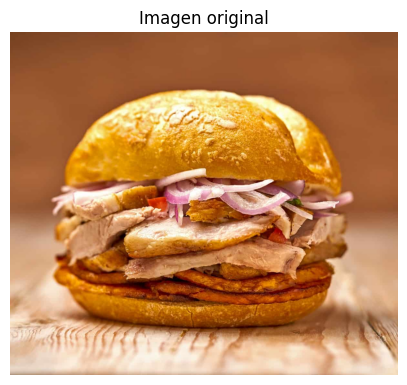

(1062, 1200, 3)

In [10]:
!wget https://comedera.com/wp-content/uploads/sites/9/2022/07/Pan-con-chicharron-limeno-shutterstock_1842217396.jpg -O pan.jpg

paths = ['pan.jpg']

img = cv2.imread(paths[0], cv2.IMREAD_COLOR)

imshow_bgr(img, "Imagen original")

img.shape

La imagen es de 1062 píxeles de alto por 1200 píxeles de alto. Recuera que `.shape` siempre te otorgará el tamaño del tensor en donde se guarda la imagen.

## Traslación de una imagen

La **traslación** consiste en **desplazar todos los píxeles** de la imagen en una dirección específica.  
En este ejemplo se utilizan los parámetros:

- `tx = 40` → desplaza la imagen **40 píxeles a la derecha**.  
- `ty = -20` → desplaza la imagen **20 píxeles hacia arriba**.  

La transformación se define mediante una **matriz de traslación** 2x3:

$$
M_t =
\begin{bmatrix}
1 & 0 & t_x \\
0 & 1 & t_y
\end{bmatrix}
$$

que aplicada a cada punto \((x, y)\) de la imagen original produce un nuevo punto:

$$
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & t_x \\
0 & 1 & t_y
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
=
\begin{bmatrix}
x + t_x \\
y + t_y
\end{bmatrix}
$$

Por tanto, cada píxel se desplaza horizontalmente en $t_x$  y verticalmente en $t_y$.

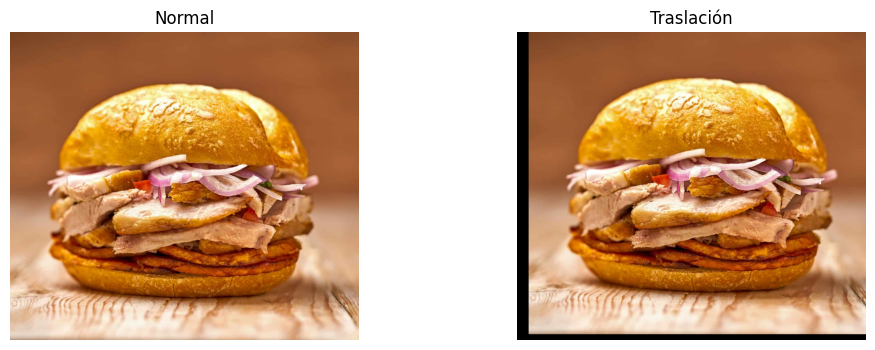

In [11]:
h, w = img.shape[:2]

# Traslación
tx, ty = 40, -20
M_t = np.float32([[1, 0, tx],[0, 1, ty]])
img_trans = cv2.warpAffine(img, M_t, (w, h))

show_side_by_side([img, img_trans], ["Normal", "Traslación"])

# Tarea 1

Genera una traslación de -30 píxeles en el eje horizontal y 30 píxeles en el eje vertical y muéstrela al lado de la imagen normal.

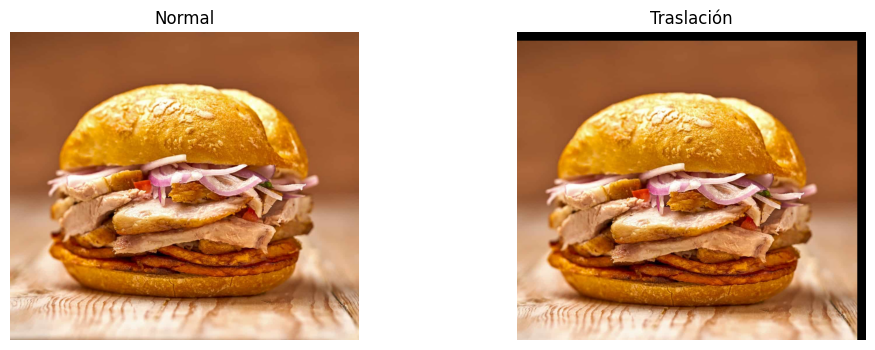

In [12]:
h, w = img.shape[:2]

# Traslación
tx, ty = -30, 30
M_t = np.float32([[1, 0, tx],[0, 1, ty]])
img_trans = cv2.warpAffine(img, M_t, (w, h))

show_side_by_side([img, img_trans], ["Normal", "Traslación"])

## Rotación de una imagen

La **rotación** consiste en girar todos los píxeles de la imagen alrededor de un **punto de referencia**, que usualmente es el **centro de la imagen**.  
En este ejemplo:

- `center = (w//2, h//2)` → centro de la imagen (coordenadas en píxeles).  
- `angle = 20` → ángulo de rotación en **grados**, positivo = sentido antihorario.  
- `scale = 1.0` → factor de escala (1 = mantiene el tamaño, >1 = amplía, <1 = reduce).


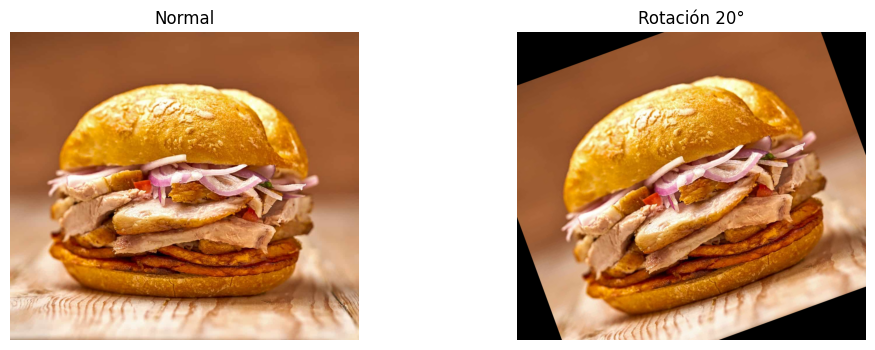

In [13]:
# Rotación
center = (w//2, h//2)
M_r = cv2.getRotationMatrix2D(center, angle=20, scale=1.0)
img_rot = cv2.warpAffine(img, M_r, (w, h))

show_side_by_side([img, img_rot], ["Normal", "Rotación 20°"])

# Tarea 2

Genera una rotación de 335 grados a partir del centro y aplica una escala que elimine los pixeles negros. Luego muestre el resutlado junto a la imagen original.

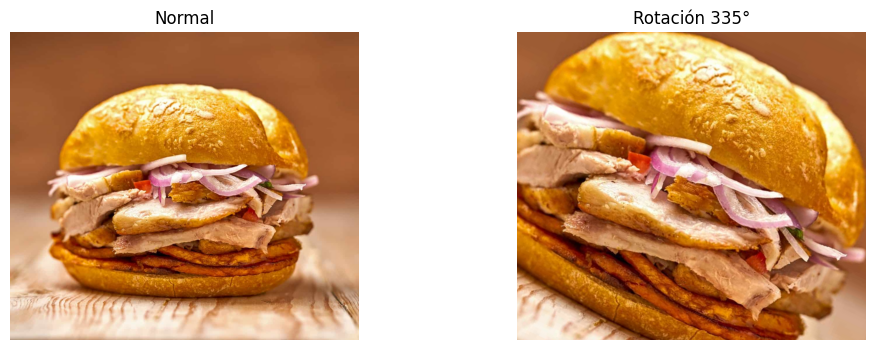

In [14]:
center = (w//2, h//2)
M_r = cv2.getRotationMatrix2D(center, angle=335, scale=1.4)
img_rot = cv2.warpAffine(img, M_r, (w, h))

show_side_by_side([img, img_rot], ["Normal", "Rotación 335°"])

## Escalado de imágenes

El **escalado** consiste en cambiar el tamaño de una imagen aplicando factores de ampliación o reducción en los ejes:

- `fx` → factor de escala en el eje **x** (horizontal).  
- `fy` → factor de escala en el eje **y** (vertical).  

En el ejemplo:

- `fx=0.1, fy=0.1` → reduce la imagen al **10%** de su tamaño original.  
- Luego se amplía esa versión pequeña al **200%** con `fx=2, fy=2`.

### Métodos de interpolación
- **`INTER_LINEAR` (bilineal):** usa 4 píxeles vecinos (2×2). Es rápido y se recomienda al **reducir** imágenes.  
- **`INTER_CUBIC` (bicúbica):** usa 16 píxeles vecinos (4×4). Es más lento pero produce bordes y detalles más suaves al **ampliar** imágenes.

De esta manera, se puede ajustar el tamaño de una imagen controlando tanto el nivel de detalle como el costo computacional.


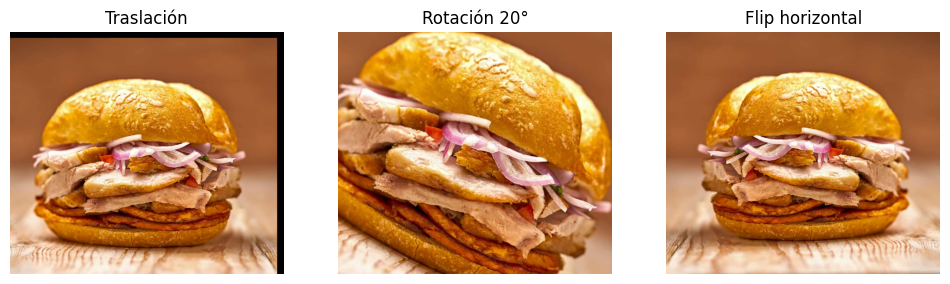

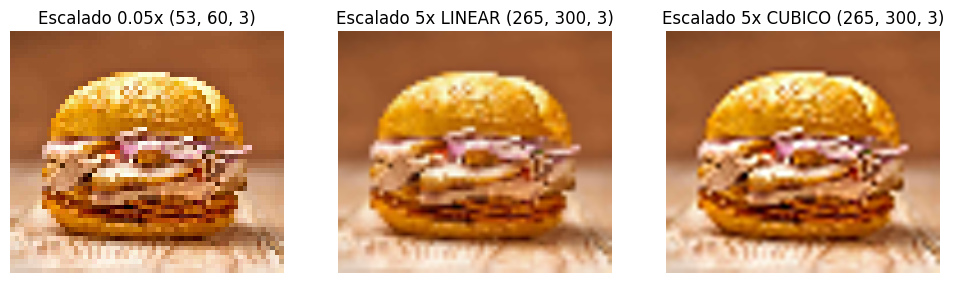

In [15]:
# Escalado
img_small = cv2.resize(img, (0,0), fx=0.05, fy=0.05, interpolation=cv2.INTER_LINEAR)
img_large_l = cv2.resize(img_small, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
img_large_c = cv2.resize(img_small, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC)

# Volteos
img_flip_h = cv2.flip(img, 1)
img_flip_v = cv2.flip(img, 0)

show_side_by_side([img_trans, img_rot, img_flip_h], ["Traslación", "Rotación 20°", "Flip horizontal"])
show_side_by_side([img_small, img_large_l, img_large_c], [f"Escalado 0.05x {img_small.shape}", f"Escalado 5x LINEAR {img_large_l.shape}", f"Escalado 5x CUBICO {img_large_c.shape}"])

# Tarea 3

¿Qué método genera mejores resultados en el escalado 5x?
¿Por qué?

El método que genera mejores resultados en el escalado 5× es Lanczos (INTER_LANCZOS4), porque este metodo realiza la interpolación
considerando un mayor número de píxeles vecinos. Por ende esto permite le calcular intensidades más precisas en los nuevos píxeles,
conservando detalles finos y bordes definidos. En cambio, Nearest Neighbor y Bilineal utilizan menos información, lo que produce
imágenes pixeladas o borrosas al ampliar tanto la escala.


## 2) Histogramas
Un **histograma** cuenta cuántos píxeles hay en cada nivel de intensidad (0–255).  
- En **grises**: 1 canal.  
- En **color**: por canal (B, G, R).  
Usos: analizar brillo/contraste y preparar **ecualización**.


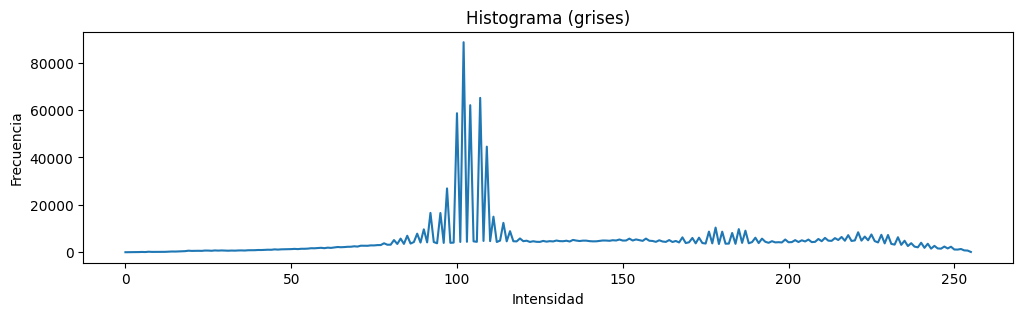

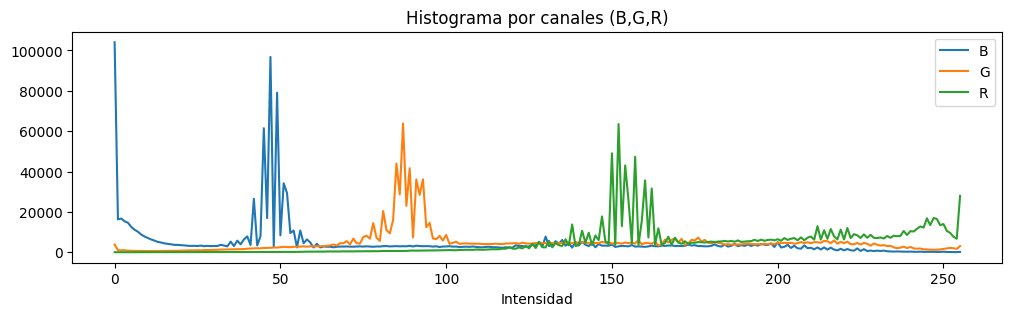

In [16]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Histograma en grises
hist_gray = cv2.calcHist([gray],[0],None,[256],[0,256]).ravel()

# Histogramas por canal
hist_b = cv2.calcHist([img],[0],None,[256],[0,256]).ravel()
hist_g = cv2.calcHist([img],[1],None,[256],[0,256]).ravel()
hist_r = cv2.calcHist([img],[2],None,[256],[0,256]).ravel()

plt.figure(figsize=(12,3))
plt.plot(hist_gray); plt.title("Histograma (grises)"); plt.xlabel("Intensidad"); plt.ylabel("Frecuencia"); plt.show()

plt.figure(figsize=(12,3))
plt.plot(hist_b, label='B'); plt.plot(hist_g, label='G'); plt.plot(hist_r, label='R')
plt.title("Histograma por canales (B,G,R)"); plt.xlabel("Intensidad"); plt.legend(); plt.show()

# Tarea 4

El histograma muestra que el canal R es el de mayor intesidad, seguido por el canal G.

Sin embargo, se ven pocos colores ROJOS y VERDES en la imagen.

¿Por qué?


Porque los valores altos en los canales R y G no significan que aparezcan colores puros, sino que al combinarse forman otros tonos como
amarillos. Por eso, aunque el histograma muestre mayor intensidad en R y G, no se ven muchos colores rojos o verdes en la imagen.